In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import json

In [ ]:
# all_player_id  = {}
# for fp in os.listdir('./Data/PlayerOfClub'):
#         try:
#             with open(os.path.join('./Data/PlayerOfClub/', fp), 'rb') as f:
#                 playerofclub = json.load(f)
#                 for p in playerofclub:
#                     if p['clubId'] not in all_player.keys():
#                         all_player[p['clubId']] = []
#                     else:
#                         all_player[p['clubId']] = all_player[p['clubId']] + p['playerId']
#         except:
#             print(fp)

In [2]:
all_player  = []
keys = []
for fp in os.listdir('./Data/Players/'):
    with open(os.path.join('./Data/Players/', fp), 'rb') as f:
        try:
            players = json.load(f)
            for p in players:
                if p['id'] not in keys:
                    keys.append(p['id'])
                    all_player.append(p)
        except:
            print(fp)

In [3]:
len(all_player)

6589

In [4]:
def fill_nan_with(df, atype='mean'):
    if atype == 'mean':
        return df.fillna(df.mean())
    elif atype == 'max':
        return df.fillna(df.max())
    elif atype == 'min':
        return df.fillna(df.min())
    elif atype == '0':
        return df.fillna(0)

In [5]:
## Flatten stats
_stats = [{stat['name']:int(stat['value']) for stat in p['stats']} for p in all_player]
for i in range(len(all_player)):
    all_player[i].update(_stats[i])
    all_player[i].pop('stats')

In [6]:
all_player = pd.json_normalize(all_player)

In [7]:
all_player.head(3)

,teamid,id,playerId,appearances,clean_sheet,draws,goals,goal_assist,losses,wins,...,assist_attempt_saved,assist_free_kick_won,att_pen_post,att_rf_miss,assist_handball_won,fifty_fifty,successful_fifty_fifty,assist_blocked_shot,assist_post,att_lf_miss
0,21,274.0,817.0,118.0,17.0,33.0,10.0,8.0,43.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,212.0,813.0,125.0,26.0,41.0,20.0,13.0,41.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,554.0,534.0,54.0,4.0,12.0,NaN,2.0,23.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#df = goals replace_mean(goals, groupby='info.info.position')

In [8]:
info_cols = ['id','playerId','teamid', 'info.name.display', 'info.info.position', 'info.nationalTeam.country', 'info.age']

general_cols = ['appearances', 'wins', 'losses', 'draws']

gk_cols = ['goals_conceded', 'clean_sheet', 'error_lead_to_goal', 'error_lead_to_shot', 'own_goals', 'saves', 'penalty_save', 'penalty_faced']

df_cols = ['goals_conceded', 'clean_sheet', 'duel_lost', 'duel_won', 'aerial_lost', 'aerial_won','error_lead_to_goal', 'error_lead_to_shot', 
           'interception', 'effective_clearance','won_tackle', 'head_clearance',
           'fifty_fifty', 'successful_fifty_fifty','outfielder_block',
           'ball_recovery', 'last_man_tackle','won_contest', 'total_contest', 'total_tackle']
mid_cols = ['touches', 'unsuccessful_touch','goal_assist','goals', 'total_pass', 'accurate_pass',
            'accurate_long_balls', 'total_long_balls', 'big_chance_created', 'big_chance_scored',
            'big_chance_missed', 'att_freekick_goal', 'att_pen_goal'
            ]
fw_cols = ['big_chance_created', 'big_chance_scored',
            'big_chance_missed', 'goals', 'goal_assist' ,'total_scoring_att', 'ontarget_scoring_att', 'att_pen_goal']

In [9]:
filter_cols = list(set(info_cols + general_cols + gk_cols + df_cols + mid_cols + fw_cols))

In [10]:
all_player = all_player[filter_cols]

In [11]:
for col in filter_cols:
    if col in info_cols:
        continue
    else:
        all_player[col] = all_player[col].fillna(0)

In [15]:
def compute_rate(col):
    return all_player[col]/(all_player['appearances'])
def compute_exc(col1, col2):
    return all_player[col1]/(all_player[col2])
    
def compute_mutual(col1, col2):
    return all_player[col1]/(all_player[col2] + all_player[col1])
def compute_dominate(col):
    return all_player[col]/all_player[col].max()

In [12]:
all_player = all_player[all_player['appearances']!=0]

In [13]:
len(all_player)

6587

In [16]:
new_rate_cols = []
for col in filter_cols:
    if col in info_cols:
        new_rate_cols.append(col)
    elif col =='appearances':
        new_col = col + '_rate'
        new_rate_cols.append(new_col)
        all_player[new_col] = compute_dominate(col)
    elif col in ['penalty_save', 'penalty_faced', 'duel_lost', 'unsuccessful_touch', 'aerial_won',
                 'won_contest', 'aerial_lost', 'won_tackle', 'duel_won', 'accurate_pass',
                 'accurate_long_balls', 'successful_fifty_fifty', 'total_contest', 'total_pass', 'total_long_balls',
                 'total_tackle', 'touches', 'fifty_fifty']:
        
        if col in ['total_pass', 'total_tackle', 'touches', 'total_long_balls', 'total_contest']:
            new_col = col + '_freq'
            all_player[new_col] = compute_dominate(col)
            new_rate_cols.append(new_col)
    
    else:
        new_col = col + '_rate'
        all_player[new_col] = compute_rate(col)
        
        new_rate_cols.append(new_col)

all_player['penalty_rate'] = compute_exc('penalty_save', 'penalty_faced')
all_player['duel_rate'] = compute_mutual('duel_won', 'duel_lost')
all_player['contest_rate'] = compute_exc('won_contest','total_contest')
all_player['tackle_rate'] = compute_exc('won_tackle', 'total_tackle')
all_player['touch_rate'] = 1-compute_exc('unsuccessful_touch', 'touches')
all_player['aerial_rate'] = compute_mutual('aerial_won', 'aerial_lost')
all_player['fiftyfifty_rate'] = compute_exc('successful_fifty_fifty', 'fifty_fifty')
all_player['pass_rate'] = compute_exc('accurate_pass', 'total_pass')
all_player['longball_rate'] = compute_exc('accurate_long_balls', 'total_long_balls')

new_rate_cols = new_rate_cols + ['penalty_rate', 'duel_rate', 'contest_rate', 'tackle_rate',
                                 'touch_rate', 'aerial_rate', 'fiftyfifty_rate', 'pass_rate', 'longball_rate']

/home/khangt1k25/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/khangt1k25/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/khangt1k25/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [18]:
new_players = all_player[new_rate_cols]

In [31]:
new_players.to_csv('./PreprocessedData/new_player_v2.csv')

In [35]:
split = 'appearances_rate'
new_players.sort_values([split], ascending=False)[['info.name.display', split, 'info.info.position']].head(10)

,info.name.display,appearances_rate,info.info.position
622,Gareth Barry,1.000000,M
508,Ryan Giggs,0.967841,M
478,Frank Lampard,0.932619,M
381,David James,0.875957,G
1612,James Milner,0.869832,M
591,Gary Speed,0.819296,M
307,Emile Heskey,0.790199,F
874,Mark Schwarzer,0.787136,G
369,Jamie Carragher,0.777948,D
524,Phil Neville,0.773354,M


## Player position

In [36]:
another_filters = ['effective_clearance_rate', 'big_chance_scored_rate', 'draws_rate',
       'own_goals_rate', 'goal_assist_rate',
       'goals_rate', 'losses_rate', 'big_chance_created_rate', 'saves_rate',
       'ontarget_scoring_att_rate', 'wins_rate', 'att_freekick_goal_rate',
       'total_long_balls_freq', 'last_man_tackle_rate', 'ball_recovery_rate',
       'att_pen_goal_rate', 'touches_freq', 'head_clearance_rate',
       'clean_sheet_rate', 'interception_rate',
       'big_chance_missed_rate', 'total_scoring_att_rate',
       'appearances_rate', 'outfielder_block_rate',
       'total_tackle_freq', 'total_contest_freq', 'total_pass_freq',
       'goals_conceded_rate', 'error_lead_to_shot_rate',
       'error_lead_to_goal_rate',  'penalty_rate',
       'duel_rate', 'contest_rate', 'tackle_rate', 'touch_rate', 'aerial_rate',
       'fiftyfifty_rate', 'pass_rate', 'longball_rate', 
       'info.info.position', 'teamid', 'info.age','info.name.display','playerId','id']

In [37]:
new_players = new_players[another_filters]

In [44]:
# new_players.loc[new_players['appearances_rate'].idxmax()]
# new_players.sort_values(['appearances_rate'], ascending=False).groupby('item').head(10)

In [38]:
new_players.dropna(subset=['info.info.position'], inplace=True)

/home/khangt1k25/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
X =  new_players.to_numpy()
y  = X[:, -6]
y[y=='S'] = 3
y[y=='F'] = 3
y[y=='G'] = 0
y[y=='D'] = 1
y[y=='M'] = 2
X = X[:,:-6]

In [41]:
X.shape, y.shape

((6584, 39), (6584,))

In [42]:
X = np.asarray(X, dtype='float64')
y = np.asarray(y, dtype='int')

In [222]:
# X_rep = simpleHead.net(torch.from_numpy(X).float())
# X_rep.shape
# X_rep = np.asarray(X_rep.detach().numpy(), dtype='float64')

In [43]:
from sklearn.manifold import TSNE

In [44]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

In [45]:
X_embedded.shape, y.shape

((6584, 2), (6584,))

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

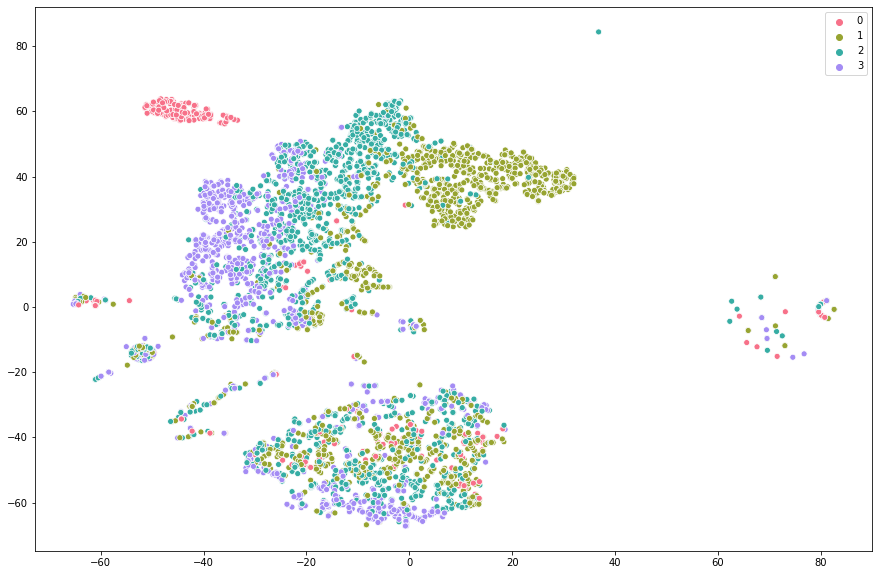

In [47]:
plt.figure(figsize=(15,10))
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=df.loc[rndperm,:],
#     legend="full",
#     alpha=0.3
# )
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette=sns.color_palette("husl", 4), legend='full',
               alpha=1.0)

In [48]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import svm    
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [49]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [50]:
lin_clf = svm.LinearSVC()
lin_clf.fit(trainX, trainy)

/home/khangt1k25/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [51]:
accuracy_score(testy, lin_clf.predict(testX))

0.5816249050873197

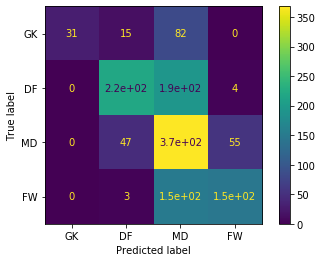

In [52]:
cm = confusion_matrix(testy,lin_clf.predict(testX))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GK', 'DF', 'MD', 'FW'])
disp.plot()
plt.show()

## Naive bayess

In [53]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)
gnb.fit(trainX, trainy)

GaussianNB(priors=None, var_smoothing=1e-09)

In [54]:
accuracy_score(testy, gnb.predict(testX))

0.39863325740318906

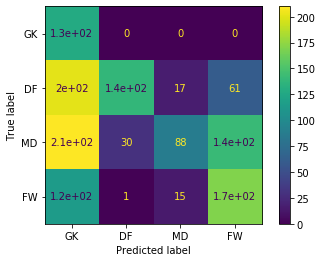

In [55]:
cm = confusion_matrix(testy, gnb.predict(testX))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GK', 'DF', 'MD', 'FW'])
disp.plot()
plt.show()

## Neural Networks

In [134]:
class CustomeDataset(torch.utils.data.Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.y.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [137]:
trainSet = CustomeDataset(trainX, trainy)
testSet = CustomeDataset(testX, testy)

In [138]:
len(testSet), len(trainSet)

(886, 3543)

In [139]:
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=256, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=128, shuffle=True)

In [175]:
class SimpleClassification(nn.Module):
    def __init__(self, num_feat, num_class):
        super(SimpleClassification, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_feat, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,  num_class),
        )
    def forward(self, x):
        output = self.net(x)
        output = torch.softmax(output, dim=1)
        return output

class SimpleClassificationv2(nn.Module):
    def __init__(self, num_feat, num_class):
        super(SimpleClassification, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_feat, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,  num_class),
        )
    def forward(self, x):
        output = self.net(x)
        output = torch.softmax(output, dim=1)
        return output
    

class SimpleAutoEncoder(nn.Module):
    def __init__(self, num_feat):
        super(SimpleAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_feat, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,  64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, num_feat),
        )
    def forward(self, x):
        rep = self.encoder(x)
        output = self.decoder(rep)
        return rep, output

In [200]:
# simpleAE = SimpleAutoEncoder(39)
simpleHead = SimpleClassification(39, 4)

In [201]:
# optimizer = torch.optim.Adam(list(simpleHead.parameters())+list(simpleAE.parameters()))
# optimizer = torch.optim.Adam(simpleAE.parameters())
optimizer = torch.optim.Adam(simpleHead.parameters())

In [202]:
criterion = nn.CrossEntropyLoss()
mse = nn.MSELoss()

In [204]:
best_global = 0
for epoch in range(100):
    acc1 = 0 
    c = 0
    for i, batch in enumerate(trainLoader):
        inp, gt = batch
        inp = inp.float()
        gt = gt.long()
#         rep, xhat = simpleAE(inp)
#         pred = simpleHead(rep)
        pred = simpleHead(inp)
#         loss = mse(xhat, inp) + criterion(pred, gt)
        loss = criterion(pred, gt)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        acc1 += loss.item()
        c+=1
        
    with open('./justhead_trainloss.txt', 'a') as f:
        f.write(str(acc1/c))
        f.write('\n')
    with torch.no_grad():
        acc1 = 0 
        c = 0
        for i, batch in enumerate(testLoader):
            inp, gt = batch
            inp = inp.float()
            gt = gt.long()

            pred = simpleHead(inp)
            pred = torch.argmax(pred, dim=1)

            acc = torch.sum(pred == gt)
            acc = acc.item()/pred.shape[0]
            acc1 += acc
            c+=1

        print("test loss:", acc1/c)
        with open('./justhead_testacc.txt', 'a') as f:
            f.write(str(acc1/c))
            f.write('\n')

        if (acc1/c > best_global):
            best_global = acc1/c
            print('saved')
            torch.save({'head': simpleHead.state_dict()}, './justhead.pth')


test loss: 0.33508625907990314
saved
test loss: 0.3805614406779661
saved
test loss: 0.48651256053268765
saved
test loss: 0.49644370460048426
saved
test loss: 0.521129691283293
saved
test loss: 0.5625945823244553
saved
test loss: 0.574871368038741
saved
test loss: 0.6191548123486683
saved
test loss: 0.6374092009685229
saved
test loss: 0.6521829600484261
saved
test loss: 0.6536773607748183
saved
test loss: 0.6590685532687652
saved
test loss: 0.662681598062954
saved
test loss: 0.6694915254237289
saved
test loss: 0.6841707021791767
saved
test loss: 0.6909806295399515
saved
test loss: 0.6850219430992736
test loss: 0.6899402239709442
test loss: 0.7008361077481841
saved
test loss: 0.6923804479418887
test loss: 0.7106915859564165
saved
test loss: 0.7111644975786925
saved
test loss: 0.7073433716707022
test loss: 0.711353662227603
saved
test loss: 0.7108807506053268
test loss: 0.7100484261501211
test loss: 0.7174825968523003
saved
test loss: 0.7198093220338982
saved
test loss: 0.7190715799031476

In [205]:
checkpoint = torch.load('./justhead.pth')
# msg1 = simpleAE.load_state_dict(checkpoint['ae'])
msg2 = simpleHead.load_state_dict(checkpoint['head'])
msg1, msg2

(<All keys matched successfully>, <All keys matched successfully>)

In [185]:
X_rep, _ = simpleAE(torch.from_numpy(X).float())

In [186]:
X_rep.shape

torch.Size([4429, 16])

In [119]:
testPredict = simpleModel(torch.from_numpy(testX).float())

In [121]:
testPredict = torch.argmax(testPredict, dim=1)

In [125]:
testPredict = testPredict.numpy()

In [127]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

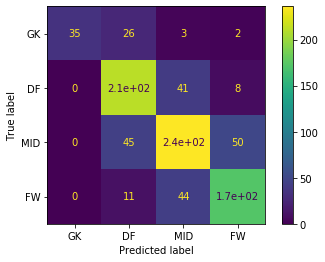

In [133]:
cm = confusion_matrix(testY, testPredict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GK', 'DF', 'MID', 'FW'])
disp.plot()
plt.show()

In [69]:
a =  compute_dominate('appearances')*2+ compute_rate('clean_sheet')+ compute_rate('saves')+ compute_exc('penalty_save', 'penalty_faced') +\
compute_rate('wins')
b = compute_rate('goals_conceded') + compute_rate('own_goals')+ compute_rate('losses')+\
compute_rate('error_lead_to_goal') + compute_rate('error_lead_to_shot')

all_player['gk_point'] = a/(b+1)

/home/khangt1k25/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
c = compute_dominate('appearances')*5 + compute_rate('clean_sheet') + compute_mutual('duel_won', 'duel_lost')+ compute_mutual('aerial_won', 'aerial_lost')+\
compute_rate('wins') + compute_rate('interception') + compute_rate('effective_clearance') +\
compute_exc('won_contest', 'total_contest') + compute_exc('successful_fifty_fifty', 'fifty_fifty')
d = compute_rate('goals_conceded') + compute_rate('own_goals')+ compute_rate('losses') +\
compute_rate('error_lead_to_goal') + compute_rate('error_lead_to_shot')

all_player['df_point'] = c/(d+1)

/home/khangt1k25/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [71]:
e = compute_dominate('appearances')*5 + compute_rate('goal_assist')*10 + compute_rate('goals') + compute_rate('big_chance_scored')+ compute_rate('big_chance_created')+\
compute_exc('accurate_pass', 'total_pass') + compute_exc('accurate_long_balls', 'total_long_balls') +\
compute_rate('att_freekick_goal') + compute_rate('att_pen_goal') + compute_rate('wins')

f = compute_exc('unsuccessful_touch', 'touches') + compute_rate('big_chance_missed') + compute_rate('losses')

all_player['mid_point'] = e/(f+1)

/home/khangt1k25/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [72]:
g = compute_dominate('appearances')*5 +compute_rate('goal_assist') + compute_rate('goals')*10 + compute_rate('big_chance_scored')+ compute_rate('big_chance_created')+\
+ compute_rate('att_pen_goal') + compute_rate('wins') + compute_exc('ontarget_scoring_att', 'total_scoring_att') +\
compute_rate('total_scoring_att')

h = compute_rate('big_chance_missed') + compute_rate('losses')

all_player['fw_point'] = g/(h+1)

/home/khangt1k25/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
for i in [508, 478, 507, ]

In [73]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

In [27]:
# for col in ['gk_point', 'df_point', 'mid_point', 'fw_point']:
#     all_player[col] = normalize(all_player[col])

In [74]:
# cols = ['gk_point', 'df_point', 'mid_point', 'fw_point']
# for j,i in enumerate(['G', 'D', 'M', 'F']):
#     tmp = all_player[all_player['info.info.position']==i]
#     col = cols[j]
#     tmp[col] = normalize(tmp[col])
#     all_player[all_player['info.info.position']==i] = tmp
    

In [75]:
all_player[['info.name.display','info.info.position', 'gk_point', 'df_point', 'mid_point', 'fw_point']].sort_values(by='gk_point', ascending=False).head(50)

,info.name.display,info.info.position,gk_point,df_point,mid_point,fw_point
1509,Ján Mucha,G,3.754594,2.261485,1.478729,0.681981
624,Richard Walker,F,3.000000,3.000000,3.000000,3.000000
4457,Sergio Romero,G,2.847626,1.202399,1.408444,0.492088
1357,Petr Cech,G,2.397365,3.950721,4.303421,3.438585
508,Ryan Giggs,M,2.136434,5.517016,8.357613,7.195859
1452,David de Gea,G,2.079160,2.835277,3.518081,2.653869
381,David James,G,2.078100,4.366723,4.150398,3.543659
1506,Tim Howard,G,2.050353,3.121507,3.516546,3.209267
3929,Caoimhin Kelleher,G,2.006126,1.181981,1.295899,0.418377
1441,Ben Amos,G,2.003063,1.507657,1.689475,0.507657


In [30]:
all_player.to_csv('./PreprocessedData/all_player.csv')

# Type of player

In [135]:
goalkeeper = []
defender = []
midfielder = []
forwarder = []
for p in all_player:
    try:
        pos = p['info']['info']['position']
        if pos == 'G':
            goalkeeper.append(p)
        elif pos == 'D':
            defender.append(p)
        elif pos == 'M':
            midfielder.append(p)
        elif pos == 'F':
            forwarder.append(p)
    except:
        print(p['info']['info'])

{'loan': True}
{'loan': True}
{'loan': True}


In [136]:
len(goalkeeper), len(defender), len(midfielder), len(forwarder)

(638, 2091, 2350, 1504)

In [137]:
for col in gk_cols:
    if col not in ['id','playerId','teamid', 'info.name.display', 'info.nationalTeam.country', 'info.age']:
        atype = None
        if col in ['appearances', 'penalty_faced']:
            atype = 'mean'
        elif col in ['clean_sheet', 'saves', 'penalty_save', 'wins', 'draws', 'losses']:
            atype = 'min'
        else:
            atype = 'max'
            
        gk[col] = replace_with(gk[col], atype=atype)

# For GK

In [138]:
## Flatten stats
goalkeeper_stats = [{stat['name']:int(stat['value']) for stat in p['stats']} for p in goalkeeper]
for i in range(len(goalkeeper)):
    goalkeeper[i].update(goalkeeper_stats[i])
    goalkeeper[i].pop('stats')

In [139]:
gk = pd.json_normalize(goalkeeper)

In [140]:
gk.head()

,teamid,id,playerId,appearances,clean_sheet,draws,goal_assist,losses,red_card,wins,...,att_freekick_target,att_obox_target,att_rf_target,att_sv_low_left,total_offside,att_goal_high_right,att_hd_goal,att_ibox_goal,total_pull_back,att_bx_right
0,9,226.0,217.0,35.0,13.0,12.0,1.0,10.0,1.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30,1481.0,1777.0,9.0,1.0,1.0,NaN,6.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30,1311.0,1549.0,30.0,5.0,4.0,NaN,17.0,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1330.0,1573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,1329.0,1572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Drop some columns

In [141]:
gk = gk[['id','playerId','teamid', 'info.name.display', 'info.nationalTeam.country', 'info.age',
   'appearances', 'clean_sheet', 'goals_conceded', 'error_lead_to_goal', 'error_lead_to_shot', 'own_goals', 'saves', 
   'penalty_save', 'penalty_faced', 'wins', 'draws', 'losses']]

In [143]:
gk_cols = ['id','playerId','teamid', 'info.name.display', 'info.nationalTeam.country', 'info.age',
   'appearances', 'clean_sheet', 'goals_conceded', 'error_lead_to_goal', 'error_lead_to_shot', 'own_goals', 'saves', 
   'penalty_save', 'penalty_faced', 'wins', 'draws', 'losses']

In [144]:
col_for_gk = ['appearances','clean_sheet_rate', 'saves_rate', 'goals_conceded_rate',
              'error_lead_to_goal_rate', 'error_lead_to_shot_rate', 'own_goals_rate',
             'penalty_rate', 'wins_rate', 'draws_rate', 'losses_rate']

### Fill NaN value

In [145]:
def replace_with(df, atype='mean'):
    if atype == 'mean':
        return df.fillna(df.mean())
    elif atype == 'max':
        return df.fillna(df.max())
    elif atype == 'min':
        return df.fillna(df.min())

In [146]:
for col in gk_cols:
    if col not in ['id','playerId','teamid', 'info.name.display', 'info.nationalTeam.country', 'info.age']:
        atype = None
        if col in ['appearances', 'penalty_faced']:
            atype = 'mean'
        elif col in ['clean_sheet', 'saves', 'penalty_save', 'wins', 'draws', 'losses']:
            atype = 'min'
        else:
            atype = 'max'
            
        gk[col] = replace_with(gk[col], atype=atype)

In [147]:
# gk['appearances'] = gk['appearances'].fillna(1)
# gk['clean_sheet']=gk['clean_sheet'].fillna(0)
# gk['goals_conceded']=gk['goals_conceded'].fillna(0)
# gk['error_lead_to_goal'] =  gk['error_lead_to_goal'].fillna(0)
# gk['error_lead_to_shot'] = gk['error_lead_to_shot'].fillna(0)
# gk['own_goals'] = gk['own_goals'].fillna(0)
# gk['saves'] = gk['saves'].fillna(0)
# gk['penalty_save']=gk['penalty_save'].fillna(0)
# gk['penalty_faced']=gk['penalty_faced'].fillna(1)
# gk['wins']=gk['wins'].fillna(0)
# gk['losses']=gk['losses'].fillna(0)
# gk['draws']=gk['draws'].fillna(0)

### Calculate rate columns

In [148]:
gk['clean_sheet_rate'] = gk['clean_sheet']/gk['appearances']
gk['saves_rate'] = gk['saves']/gk['appearances']
gk['goals_conceded_rate'] = gk['goals_conceded']/gk['appearances']
gk['error_lead_to_goal_rate'] = gk['error_lead_to_goal']/gk['appearances']
gk['error_lead_to_shot_rate'] = gk['error_lead_to_shot']/gk['appearances']
gk['own_goals_rate'] = gk['own_goals']/gk['appearances']
gk['penalty_rate'] = gk['penalty_save']/gk['penalty_faced']
gk['wins_rate'] = gk['wins']/gk['appearances']
gk['draws_rate'] = gk['draws']/gk['appearances']
gk['losses_rate'] = gk['losses']/gk['appearances']

In [149]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

In [150]:
for col in col_for_gk:
    gk[col] = normalize(gk[col])

## Calculate point for GK

In [160]:
# Case 1:
# gk['point'] = gk['appearances'] + gk['clean_sheet_rate']+\
#     gk['saves_rate']+gk['penalty_rate']+\
#     -gk['goals_conceded_rate']-gk['own_goals_rate']+\
#     gk['wins_rate']-gk['losses_rate']+\
#     -gk['error_lead_to_goal_rate']-gk['error_lead_to_shot_rate']
# Case 2:
a = gk['appearances']**2*(gk['clean_sheet_rate']**5)*(gk['saves_rate'])*gk['penalty_rate']*gk['wins_rate']**2
b = gk['goals_conceded_rate']**2*gk['own_goals_rate']*gk['losses_rate']**2*gk['error_lead_to_goal_rate']**2
*gk['error_lead_to_shot_rate']

gk['point'] = np.log((a+1)/(b+1))

In [161]:
gk['point'] = normalize(gk['point'])

In [162]:
gk[['info.name.display', 'point']].sort_values(by='point', ascending=False).head(50)

,info.name.display,point
131,Petr Cech,1.000000
163,Joe Hart,0.999905
371,Ederson,0.999881
151,Pepe Reina,0.999876
146,Tim Howard,0.999859
186,Hugo Lloris,0.999854
216,Manuel Almunia,0.999849
140,David de Gea,0.999849
202,Simon Mignolet,0.999848
254,Edwin van der Sar,0.999846


In [163]:
gk.to_csv('./gk.csv')

## For DF

In [164]:
## Flatten stats
defender_stats = [{stat['name']:int(stat['value']) for stat in p['stats']} for p in defender]
for i in range(len(defender)):
    defender[i].update(defender_stats[i])
    defender[i].pop('stats')

In [165]:
dfer = pd.json_normalize(defender)

In [166]:
dfer.head(5)

,teamid,id,playerId,appearances,clean_sheet,draws,goal_assist,losses,wins,yellow_card,...,punches,total_high_claim,att_pen_miss,att_lf_miss,dive_catch,diving_save,accurate_keeper_sweeper,total_keeper_sweeper,back_pass,stand_save
0,21,554.0,534.0,54.0,4.0,12.0,2.0,23.0,19.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,960.0,29919.0,152.0,31.0,36.0,7.0,65.0,51.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,1244.0,1456.0,27.0,5.0,7.0,1.0,12.0,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,229.0,1884.0,174.0,52.0,58.0,10.0,56.0,60.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,1486.0,279138.0,9.0,2.0,2.0,NaN,4.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
df_cols = ['id','playerId','teamid', 'info.name.display', 'info.nationalTeam.country', 'info.age',
             'appearances', 'clean_sheet', 'duel_lost', 'duel_won', 'aerial_lost', 'aerial_won',
             'error_lead_to_goal', 'error_lead_to_shot', 'interception', 'effective_clearance',
             'won_tackle', 'total_tackle', 'wins', 'draws', 'losses',
             'head_clearance', 'fifty_fifty', 'successful_fifty_fifty',
             'outfielder_block', 'goals_conceded', 'ball_recovery', 'last_man_tackle',
             'won_contest', 'total_contest'
            ]

In [168]:
dfer = dfer[df_cols]

In [169]:
def replace_with(df, atype='mean'):
    if atype == 'mean':
        return df.fillna(df.mean())
    elif atype == 'max':
        return df.fillna(df.max())
    elif atype == 'min':
        return df.fillna(df.min())

In [170]:
for col in df_cols:
    if col not in ['id','playerId','teamid', 'info.name.display', 'info.nationalTeam.country', 'info.age']:
        atype = None
        if col in ['appearances', 'total_tackle', 'total_contest']:
            atype = 'mean'
        elif col in ['clean_sheet', 'interception', 'effective_clearance', 'wins', 'head_clearance', 'successful_fifty_fifty',
                    'outfielder_block', 'ball_recovery', 'last_man_tackle', 'won_contest']:
            atype = 'min'
        else:
            atype = 'max'
            
        dfer[col] = replace_with(dfer[col], atype=atype)

In [157]:
# dfer['appearances'] = dfer['appearances'].fillna(1)
# dfer['clean_sheet']=dfer['clean_sheet'].fillna(0)
# dfer['duel_lost']=dfer['duel_lost'].fillna(0)
# dfer['duel_won'] = dfer['duel_won'].fillna(0)
# dfer['aerial_lost'] =  dfer['aerial_lost'].fillna(0)
# dfer['aerial_won'] = dfer['aerial_won'].fillna(0)
# dfer['error_lead_to_goal'] = dfer['error_lead_to_goal'].fillna(0)
# dfer['error_lead_to_shot']=dfer['error_lead_to_shot'].fillna(0)
# dfer['interception']=dfer['interception'].fillna(0)
# dfer['effective_clearance'] = dfer['effective_clearance'].fillna(0)
# dfer['won_tackle']=dfer['won_tackle'].fillna(0)
# dfer['total_tackle']=dfer['total_tackle'].fillna(1)
# dfer['wins']=dfer['wins'].fillna(0)
# dfer['losses']=dfer['losses'].fillna(0)
# dfer['draws']=dfer['draws'].fillna(0)

# dfer['head_clearance'] = dfer['head_clearance'].fillna(0)
# dfer['fifty_fifty'] = dfer['fifty_fifty'].fillna(1)
# dfer['successful_fifty_fifty'] = dfer['successful_fifty_fifty'].fillna(0)
# dfer['outfielder_block'] = dfer['outfielder_block'].fillna(0)
# dfer['goals_conceded'] = dfer['outfielder_block'].fillna(0)
# dfer['ball_recovery'] = dfer['ball_recovery'].fillna(0)
# dfer['last_man_tackle'] = dfer['last_man_tackle'].fillna(0)
# dfer['total_contest'] = dfer['total_contest'].fillna(1)
# dfer['won_contest'] = dfer['won_contest'].fillna(0)


In [171]:
dfer['clean_sheet_rate'] = dfer['clean_sheet']/dfer['appearances']
dfer['error_lead_to_goal_rate'] = dfer['error_lead_to_goal']/dfer['appearances']
dfer['error_lead_to_shot_rate'] = dfer['error_lead_to_shot']/dfer['appearances']
dfer['duel_rate'] = (dfer['duel_won'])/(dfer['duel_won']+ dfer['duel_lost'])
dfer['aerial_rate'] = (dfer['aerial_won'])/(dfer['aerial_won']+ dfer['aerial_lost'])
dfer['interception_rate'] = (dfer['interception'])/dfer['appearances']
dfer['effective_clearance_rate'] = dfer['effective_clearance']/dfer['appearances']
dfer['tackle_rate'] = dfer['won_tackle']/dfer['total_tackle']
dfer['wins_rate'] =dfer['wins']/dfer['appearances']
dfer['draws_rate'] = dfer['draws']/dfer['appearances']
dfer['losses_rate'] = dfer['losses']/dfer['appearances']
dfer['head_clearance_rate'] = dfer['head_clearance']/dfer['appearances']
dfer['fifty_fifty_rate'] = dfer['successful_fifty_fifty']/dfer['fifty_fifty']
dfer['outfielder_block_rate'] = dfer['outfielder_block']/dfer['appearances']
dfer['goals_conceded_rate'] = dfer['goals_conceded']/dfer['appearances']
dfer['ball_recovery_rate'] = dfer['ball_recovery']/dfer['appearances']
dfer['last_man_tackle_rate'] = dfer['last_man_tackle']/dfer['appearances']
dfer['contest_rate'] = dfer['won_contest']/dfer['total_contest']

In [172]:
col_for_df = ['appearances','clean_sheet_rate', 'duel_rate', 'aerial_rate',
              'error_lead_to_goal_rate', 'error_lead_to_shot_rate', 'interception_rate',
             'effective_clearance_rate', 'tackle_rate',
              'wins_rate', 'draws_rate', 'losses_rate',
             'head_clearance_rate', 'fifty_fifty_rate', 'outfielder_block_rate', 
              'goals_conceded_rate', 'ball_recovery_rate', 'last_man_tackle_rate', 'contest_rate']

In [173]:
for col in col_for_df:
    dfer[col] = normalize(dfer[col])

In [174]:
dfer.head(10)

,id,playerId,teamid,info.name.display,info.nationalTeam.country,info.age,appearances,clean_sheet,duel_lost,duel_won,...,wins_rate,draws_rate,losses_rate,head_clearance_rate,fifty_fifty_rate,outfielder_block_rate,goals_conceded_rate,ball_recovery_rate,last_man_tackle_rate,contest_rate
0,554.0,534.0,21,Stuart Nethercott,England,48 years 212 days,0.104536,4.0,1740.0,2032.0,...,0.342939,0.001332,0.002162,0.001821,0.0,0.0,0.018519,0.001617,0.0,0.0
1,960.0,29919.0,21,Jamie Clapham,England,45 years 316 days,0.297830,31.0,1740.0,2032.0,...,0.326389,0.001438,0.002172,0.000477,0.0,0.0,0.000013,0.000423,0.0,0.0
2,1244.0,1456.0,20,Ulrich van Gobbel,Netherlands,50 years 276 days,0.051282,5.0,1740.0,2032.0,...,0.286619,0.001600,0.002268,0.003907,0.0,0.0,0.037037,0.003470,0.0,0.0
3,229.0,1884.0,9,Tony Dorigo,England,55 years 292 days,0.341223,52.0,1740.0,2032.0,...,0.335818,0.002137,0.001567,0.000383,0.0,0.0,0.005747,0.000340,0.0,0.0
4,1486.0,279138.0,6,Kevin Muscat,Australia,48 years 73 days,0.015779,2.0,1740.0,2032.0,...,0.324166,0.001332,0.002268,0.012250,0.0,0.0,0.111111,0.010879,0.0,0.0
5,1011.0,1135.0,27,Steve McAnespie,Scotland,49 years 260 days,0.019724,1.0,1740.0,2032.0,...,0.078408,0.001039,0.003885,0.009975,0.0,0.0,0.090909,0.008858,0.0,0.0
6,205.0,1779.0,30,Neil Thompson,England,58 years 17 days,0.147929,23.0,1740.0,2032.0,...,0.253025,0.002296,0.001909,0.001218,0.0,0.0,0.013158,0.001081,0.0,0.0
7,653.0,1778.0,30,Peter Shirtliff,England,60 years 196 days,0.045365,4.0,1740.0,2032.0,...,0.408645,0.001231,0.001871,0.004429,0.0,0.0,0.041667,0.003933,0.0,0.0
8,1318.0,1556.0,30,Scott Jones,England,46 years 171 days,0.021696,1.0,1740.0,2032.0,...,0.239687,0.000325,0.003538,0.009121,0.0,0.0,0.083333,0.008100,0.0,0.0
9,98.0,1557.0,30,Darren Barnard,Wales,49 years 323 days,0.116371,9.0,1740.0,2032.0,...,0.273478,0.001171,0.002681,0.001613,0.0,0.0,0.016667,0.001432,0.0,0.0


In [204]:
# Case 2:
a = dfer['appearances']*dfer['clean_sheet_rate']**2*(dfer['duel_rate'])*\
dfer['aerial_rate']**2*dfer['interception_rate']**2 *dfer['tackle_rate']*
dfer['effective_clearance_rate']*dfer['wins_rate']**2*\
dfer['contest_rate'] * dfer['ball_recovery_rate']*dfer['head_clearance_rate']

b = dfer['losses_rate']*dfer['error_lead_to_goal_rate']*dfer['error_lead_to_shot_rate']*dfer['goals_conceded_rate']

dfer['point'] = np.log((a+1)/(b+1))

In [202]:
dfer['point'] = normalize(dfer['point'])

In [205]:
dfer[['info.name.display', 'point']].sort_values(by='point', ascending=False).head(60)

,info.name.display,point
483,Nemanja Vidic,1.734296e-07
690,Laurent Koscielny,4.870796e-08
544,Vincent Kompany,4.083123e-08
1268,Virgil van Dijk,3.401265e-08
519,Martin Skrtel,3.154186e-08
623,Jan Vertonghen,2.691776e-08
494,Brede Hangeland,1.870826e-08
484,Jonny Evans,1.866252e-08
697,Per Mertesacker,1.851745e-08
1379,Nicolás Otamendi,1.850814e-08


In [182]:
dfer.to_csv('./dfer.csv')

## Mid

In [183]:
## Flatten stats
mid_stats = [{stat['name']:int(stat['value']) for stat in p['stats']} for p in midfielder]
for i in range(len(midfielder)):
    midfielder[i].update(mid_stats[i])
    midfielder[i].pop('stats')

In [184]:
mider = pd.json_normalize(midfielder)

In [186]:
mid_cols = ['id','playerId','teamid', 'info.name.display', 'info.nationalTeam.country', 'info.age',
             'appearances', 'clean_sheet', 'wins', 'draws', 'losses', 'touches', 'unsuccessful_touch',
           'goal_assist','goals', 'total_pass', 'accurate_pass', 'accurate_long_balls', 'total_long_balls', 
           'big_chance_created', 'big_chance_scored', 'big_chance_missed'
            ]

In [187]:
mider = mider[mid_cols]

In [189]:
for col in mid_cols:
    if col not in ['id','playerId','teamid', 'info.name.display', 'info.nationalTeam.country', 'info.age']:
        atype = None
        if col in ['appearances', 'total_pass', 'total_long_balls', 'touches']:
            atype = 'mean'
        elif col in ['goal_assist', 'goals', 'wins', 'big_chance_scored', 'big_chance_created', 
                     'big_chance_missed', 'accurate_long_balls', 'accurate_pass']:
            atype = 'min'
        else:
            atype = 'max'
            
        mider[col] = replace_with(mider[col], atype=atype)

/home/khangt1k25/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [192]:
mider['wins_rate'] =mider['wins']/mider['appearances']
mider['draws_rate'] = mider['draws']/mider['appearances']
mider['losses_rate'] = mider['losses']/mider['appearances']
mider['goals_rate'] = mider['goals']/mider['appearances']
mider['goal_assist_rate'] = mider['goal_assist']/mider['appearances']
mider['big_chance_created_rate'] = mider['big_chance_created']/mider['appearances']
mider['big_chance_missed_rate'] = mider['big_chance_missed']/mider['appearances']
mider['big_chance_scored_rate'] = mider['big_chance_scored']/mider['appearances']
mider['pass_rate'] = mider['total_pass']/mider['accurate_pass']
mider['long_pass_rate'] = mider['accurate_long_balls']/mider['total_long_balls']
mider['touch_rate'] = 1- mider['unsuccessful_touch']/mider['touches']

In [193]:
col_for_mid = [ 'wins_rate', 'draws_rate', 'losses_rate', 'goals_rate', 'goal_assist_rate',
           'big_chance_created_rate','big_chance_missed_rate', 'big_chance_scored_rate', 'pass_rate', 'long_pass_rate', 'touch_rate'
            ]

In [194]:
for col in col_for_mid:
    mider[col] = normalize(mider[col])

In [219]:
# Case 2:
a = mider['appearances']**5*mider['goals_rate']*(mider['goal_assist_rate'])*\
mider['big_chance_created_rate']*mider['big_chance_scored_rate']*mider['pass_rate']*mider['long_pass_rate']*\
mider['wins_rate']*mider['touch_rate']

b = mider['losses_rate']*mider['big_chance_missed_rate']

mider['point'] = np.log((a+1)/(b+1))

In [220]:
mider['point'] = normalize(mider['point'])

In [221]:
mider[['info.name.display', 'point']].sort_values(by='point', ascending=False).head(60)

,info.name.display,point
557,David Silva,1.000000
150,Frank Lampard,0.984748
248,Steven Gerrard,0.976956
556,James Milner,0.926702
156,Ryan Giggs,0.912815
1355,Kevin De Bruyne,0.891681
639,Gylfi Sigurdsson,0.884311
453,Juan Mata,0.859263
1557,Christian Eriksen,0.852193
779,Cesc Fàbregas,0.841718


## Forward score

In [45]:
tmp = []
for p in forwardMU:
    stats = p['stats']
    appearances = 1
    wins = 0
    draws = 0 
    losses = 0
    
    goals = 0
    goal_assist = 0
    
    big_chance_scored = 0
    big_chance_missed = 0
    
    for stat in stats:
        if stat['name'] == 'wins':
            wins = stat['value']
        if stat['name'] == 'draws':
            draws = stat['value']
        if stat['name'] == 'losses':
            losses = stat['value']
    
        if stat['name'] == 'appearances':
            appearances = stat['value']
            
        if stat['name'] == 'goals':
            goals = stat['value']
        if stat['name'] == 'goal_assist':
            goal_assist = stat['value']

        
        if stat['name'] == 'big_chance_scored':
            big_chance_scored = stat['value']
        if stat['name'] == 'big_chance_missed':
            big_chance_missed = stat['value']
        
    total = (wins-losses)/appearances + (goals+goal_assist+big_chance_scored-big_chance_missed)*2/appearances     
    # fw stats
    t = {'playerId': p['playerId'],
         'name':p['info']['name']['display'], 
         'stats': [total, appearances, clean_sheet, wins, draws, losses,
                  goals, goal_assist, big_chance_scored, big_chance_missed,
                  ]}
        
    print(t)

{'playerId': 269845.0, 'name': 'Shola Shoretire', 'stats': [1.0, 2.0, 33.0, 2.0, 0, 0, 0, 0, 0, 0]}
{'playerId': 187459.0, 'name': 'Alexis Sánchez', 'stats': [1.5974025974025974, 154.0, 33.0, 86.0, 38.0, 30.0, 63.0, 31.0, 37.0, 36.0]}
{'playerId': 288674.0, 'name': "D'Mani Mellor", 'stats': [0.0, 1, 33.0, 0, 0, 0, 0, 0, 0, 0]}
{'playerId': 128343.0, 'name': 'Anthony Elanga', 'stats': [2.0, 2.0, 33.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0]}
{'playerId': 266781.0, 'name': 'Amad Diallo', 'stats': [0.6666666666666666, 3.0, 33.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 0]}
{'playerId': 258845.0, 'name': 'Edinson Cavani', 'stats': [1.2758620689655173, 29.0, 33.0, 14.0, 10.0, 5.0, 10.0, 3.0, 9.0, 8.0]}
{'playerId': 19619.0, 'name': 'Anthony Martial', 'stats': [1.2093023255813953, 172.0, 33.0, 89.0, 44.0, 39.0, 56.0, 26.0, 33.0, 36.0]}
{'playerId': 139564.0, 'name': 'Mason Greenwood', 'stats': [0.6027397260273972, 73.0, 33.0, 33.0, 23.0, 17.0, 21.0, 3.0, 3.0, 13.0]}
{'playerId': 19620.0, 'name': 'Marcus Rashford', 's